In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Reading The Dataset

In [2]:
cafesales = pd.read_csv("dirty_cafe_sales.csv")
cafesales.head()

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
0,TXN_1961373,Coffee,2,2.0,4.0,Credit Card,Takeaway,2023-09-08
1,TXN_4977031,Cake,4,3.0,12.0,Cash,In-store,2023-05-16
2,TXN_4271903,Cookie,4,1.0,ERROR,Credit Card,In-store,2023-07-19
3,TXN_7034554,Salad,2,5.0,10.0,UNKNOWN,UNKNOWN,2023-04-27
4,TXN_3160411,Coffee,2,2.0,4.0,Digital Wallet,In-store,2023-06-11


In [3]:
cafesales.tail()

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
9995,TXN_7672686,Coffee,2,2.0,4.0,NaN,UNKNOWN,2023-08-30
9996,TXN_9659401,NaN,3,NaN,3.0,Digital Wallet,NaN,2023-06-02
9997,TXN_5255387,Coffee,4,2.0,8.0,Digital Wallet,NaN,2023-03-02
9998,TXN_7695629,Cookie,3,NaN,3.0,Digital Wallet,NaN,2023-12-02
9999,TXN_6170729,Sandwich,3,4.0,12.0,Cash,In-store,2023-11-07


In [4]:
print(cafesales.shape)
print(cafesales.info())
cafesales.describe()

(10000, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Transaction ID    10000 non-null  object
 1   Item              9667 non-null   object
 2   Quantity          9862 non-null   object
 3   Price Per Unit    9821 non-null   object
 4   Total Spent       9827 non-null   object
 5   Payment Method    7421 non-null   object
 6   Location          6735 non-null   object
 7   Transaction Date  9841 non-null   object
dtypes: object(8)
memory usage: 625.1+ KB
None


,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
count,10000,9667,9862,9821,9827,7421,6735,9841
unique,10000,10,7,8,19,5,4,367
top,TXN_6170729,Juice,5,3.0,6.0,Digital Wallet,Takeaway,UNKNOWN
freq,1,1171,2013,2429,979,2291,3022,159


Taking a quick look at the dataset shows that there are errors and improper data type entries in different columns (e.g. Total Spent column). 

# Cleaning The Dataset

In [5]:
# Attempting to drop rows with null values
droped_cafesales = cafesales.dropna()
droped_cafesales.describe()

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
count,4550,4550,4550,4550,4550,4550,4550,4550
unique,4550,10,7,8,19,5,4,367
top,TXN_6170729,Juice,5,3.0,6.0,Digital Wallet,Takeaway,ERROR
freq,1,569,923,1139,464,1443,2041,68


Dropping rows deletes more than half the entries in the dataset, which is not ideal in its current state. 

Instead, the values of the columns **Item**, **Quantity**, **Price Per Unit**, and **Total Spent** will all be filled based on the other values in the dataset. For the columns **Payment Method**, **Location**, and **Transaction Date**, they will be instead filled with blank values when the value is not applicable. 

As such, these will be the steps taken in cleaning the dataset:
- Dropping duplcate rows
- Drop the Transaction ID column
- Removing leading and trailing whitespaces in all columns
- Replacing ERROR, UNKNOWN, and NaN with a blank value
- Setting the correct datatype for each column
- Filling the missing values in certain columns 
- Dropping rows with empty values in Quantity, Price Per Unit, and/or Total Spent column

## Dropping duplicates, the Transaction ID column, and Removing excess whitespaces

In [6]:
clean_cafesales = cafesales.drop_duplicates()
clean_cafesales = clean_cafesales.drop(columns='Transaction ID')
clean_cafesales.columns = clean_cafesales.columns.str.strip()

## Replacing ERROR, UNKNOWN, and NaN with a blank value 

In [7]:
clean_cafesales.replace(np.nan, None, inplace=True)
clean_cafesales.replace('ERROR', None, inplace=True)
clean_cafesales.replace('UNKNOWN', None, inplace=True)

## Setting the correct datatype for each column

In [8]:
datatype_conversion_dict = {
    'Item' : str,
    'Quantity' : float,
    'Price Per Unit' : float,
    'Total Spent' : float,
    'Payment Method' : str,
    'Location' : str,
}

clean_cafesales = clean_cafesales.astype(datatype_conversion_dict)
clean_cafesales['Transaction Date'] = pd.to_datetime(clean_cafesales['Transaction Date'])

print(clean_cafesales.dtypes)

Item                        object
Quantity                   float64
Price Per Unit             float64
Total Spent                float64
Payment Method              object
Location                    object
Transaction Date    datetime64[ns]
dtype: object


## Filling in missing values

### Price Per Unit (of each valid Item)

Blank/None values are not considered as valid Items

In [9]:
print("Blank values in Price Per Unit column: " + str(clean_cafesales['Price Per Unit'].isna().sum()))

clean_cafesales.loc[clean_cafesales['Price Per Unit'].isna(), 'Price Per Unit'] = clean_cafesales['Total Spent'] / clean_cafesales['Quantity'] 

print("Blank values in Price Per Unit column after computing: " + str(clean_cafesales['Price Per Unit'].isna().sum()))
clean_cafesales.head(15)

Blank values in Price Per Unit column: 533
Blank values in Price Per Unit column after computing: 38


,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
0,Coffee,2.0,2.0,4.0,Credit Card,Takeaway,2023-09-08
1,Cake,4.0,3.0,12.0,Cash,In-store,2023-05-16
2,Cookie,4.0,1.0,NaN,Credit Card,In-store,2023-07-19
3,Salad,2.0,5.0,10.0,None,None,2023-04-27
4,Coffee,2.0,2.0,4.0,Digital Wallet,In-store,2023-06-11
5,Smoothie,5.0,4.0,20.0,Credit Card,None,2023-03-31
6,None,3.0,3.0,9.0,None,Takeaway,2023-10-06
7,Sandwich,4.0,4.0,16.0,Cash,None,2023-10-28
8,None,5.0,3.0,15.0,None,Takeaway,2023-07-28
9,Sandwich,5.0,4.0,20.0,None,In-store,2023-12-31


In [10]:
print(clean_cafesales[['Item', 'Price Per Unit']].value_counts())
print(clean_cafesales[['Item', 'Price Per Unit']].isna().sum())

Item      Price Per Unit
Juice     3.0               1170
Coffee    2.0               1163
Salad     5.0               1146
Cake      3.0               1135
Sandwich  4.0               1126
Smoothie  4.0               1091
Cookie    1.0               1086
Tea       1.5               1082
None      3.0                247
          4.0                227
          2.0                126
          5.0                124
          1.0                121
          1.5                118
Name: count, dtype: int64
Item               0
Price Per Unit    38
dtype: int64


In [11]:
clean_cafesales['Price Per Unit'].mask(clean_cafesales['Item'] == 'Juice', '3.0', inplace=True)
clean_cafesales['Price Per Unit'].mask(clean_cafesales['Item'] == 'Coffee', '2.0', inplace=True)
clean_cafesales['Price Per Unit'].mask(clean_cafesales['Item'] == 'Cake', '3.0', inplace=True)
clean_cafesales['Price Per Unit'].mask(clean_cafesales['Item'] == 'Salad', '5.0', inplace=True)
clean_cafesales['Price Per Unit'].mask(clean_cafesales['Item'] == 'Sandwich', '4.0', inplace=True)
clean_cafesales['Price Per Unit'].mask(clean_cafesales['Item'] == 'Smoothie', '4.0', inplace=True)
clean_cafesales['Price Per Unit'].mask(clean_cafesales['Item'] == 'Cookie', '1.0', inplace=True)
clean_cafesales['Price Per Unit'].mask(clean_cafesales['Item'] == 'Tea', '1.5', inplace=True)

clean_cafesales['Price Per Unit'] = clean_cafesales['Price Per Unit'].astype(float)

print(clean_cafesales[['Item', 'Price Per Unit']].value_counts())
print(clean_cafesales[['Item', 'Price Per Unit']].isna().sum())

Item      Price Per Unit
Juice     3.0               1171
Coffee    2.0               1165
Salad     5.0               1148
Cake      3.0               1139
Sandwich  4.0               1131
Smoothie  4.0               1096
Cookie    1.0               1092
Tea       1.5               1089
None      3.0                247
          4.0                227
          2.0                126
          5.0                124
          1.0                121
          1.5                118
Name: count, dtype: int64
Item              0
Price Per Unit    6
dtype: int64


In [12]:
clean_cafesales.head(15)

,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
0,Coffee,2.0,2.0,4.0,Credit Card,Takeaway,2023-09-08
1,Cake,4.0,3.0,12.0,Cash,In-store,2023-05-16
2,Cookie,4.0,1.0,NaN,Credit Card,In-store,2023-07-19
3,Salad,2.0,5.0,10.0,None,None,2023-04-27
4,Coffee,2.0,2.0,4.0,Digital Wallet,In-store,2023-06-11
5,Smoothie,5.0,4.0,20.0,Credit Card,None,2023-03-31
6,None,3.0,3.0,9.0,None,Takeaway,2023-10-06
7,Sandwich,4.0,4.0,16.0,Cash,None,2023-10-28
8,None,5.0,3.0,15.0,None,Takeaway,2023-07-28
9,Sandwich,5.0,4.0,20.0,None,In-store,2023-12-31


### Item

As seen from the cleaning of the Price Per Unit column, there are some items in the Item column that contain the same value in Price Per Unit (e.g. Juice and Cake having a Price Per Unit of 3.0). This will be left as is and will not be labled properly.

However for the remaining items that have unique Price Per Unit values, it will be labeled with the item name associated with the unique Price Per Unit (e.g. All rows with empty Item values that have a Price Per Unit of 2.0 will be set as Coffee).

In [13]:
# For reference, these are the Item and Price Per Unit values retrieved in the previous section
# Juice     3.0 
# Cake      3.0
# Sandwich  4.0 
# Smoothie  4.0 
# Coffee    2.0 
# Salad     5.0 
# Cookie    1.0 
# Tea       1.5 

clean_cafesales.loc[clean_cafesales['Item'].isna(), 'Item'] = clean_cafesales['Item'].mask(clean_cafesales['Price Per Unit'] == 2.0, 'Coffee', inplace=True)
clean_cafesales.loc[clean_cafesales['Item'].isna(), 'Item'] = clean_cafesales['Item'].mask(clean_cafesales['Price Per Unit'] == 5.0, 'Salad', inplace=True)
clean_cafesales.loc[clean_cafesales['Item'].isna(), 'Item'] = clean_cafesales['Item'].mask(clean_cafesales['Price Per Unit'] == 1.0, 'Cookie', inplace=True)
clean_cafesales.loc[clean_cafesales['Item'].isna(), 'Item'] = clean_cafesales['Item'].mask(clean_cafesales['Price Per Unit'] == 1.5, 'Tea', inplace=True)

In [14]:
print(clean_cafesales[['Item', 'Price Per Unit']].value_counts())
print(clean_cafesales[['Item', 'Price Per Unit']].isna().sum())

Item      Price Per Unit
Coffee    2.0               1291
Salad     5.0               1272
Cookie    1.0               1213
Tea       1.5               1207
Juice     3.0               1171
Cake      3.0               1139
Sandwich  4.0               1131
Smoothie  4.0               1096
None      3.0                247
          4.0                227
Name: count, dtype: int64
Item              0
Price Per Unit    6
dtype: int64


### Quantity

In [15]:
print("Blank values in Quantity column: " + str(clean_cafesales['Quantity'].isna().sum()))

clean_cafesales.loc[clean_cafesales['Quantity'].isna(), 'Quantity'] = clean_cafesales['Total Spent'] / clean_cafesales['Price Per Unit']

print("Blank values in Quantity column after computing: " + str(clean_cafesales['Quantity'].isna().sum()))
clean_cafesales.head(15)

Blank values in Quantity column: 479
Blank values in Quantity column after computing: 23


,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
0,Coffee,2.0,2.0,4.0,Credit Card,Takeaway,2023-09-08
1,Cake,4.0,3.0,12.0,Cash,In-store,2023-05-16
2,Cookie,4.0,1.0,NaN,Credit Card,In-store,2023-07-19
3,Salad,2.0,5.0,10.0,None,None,2023-04-27
4,Coffee,2.0,2.0,4.0,Digital Wallet,In-store,2023-06-11
5,Smoothie,5.0,4.0,20.0,Credit Card,None,2023-03-31
6,None,3.0,3.0,9.0,None,Takeaway,2023-10-06
7,Sandwich,4.0,4.0,16.0,Cash,None,2023-10-28
8,None,5.0,3.0,15.0,None,Takeaway,2023-07-28
9,Sandwich,5.0,4.0,20.0,None,In-store,2023-12-31


### Total Spent

In [16]:
print("Blank values in Total Spent column: " + str(clean_cafesales['Total Spent'].isna().sum()))

clean_cafesales.loc[clean_cafesales['Total Spent'].isna(), 'Total Spent'] = clean_cafesales['Price Per Unit'] * clean_cafesales['Quantity'] 

print("Blank values in Total Spent column after computing: " + str(clean_cafesales['Total Spent'].isna().sum()))
clean_cafesales.head(15)

Blank values in Total Spent column: 502
Blank values in Total Spent column after computing: 23


,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
0,Coffee,2.0,2.0,4.0,Credit Card,Takeaway,2023-09-08
1,Cake,4.0,3.0,12.0,Cash,In-store,2023-05-16
2,Cookie,4.0,1.0,4.0,Credit Card,In-store,2023-07-19
3,Salad,2.0,5.0,10.0,None,None,2023-04-27
4,Coffee,2.0,2.0,4.0,Digital Wallet,In-store,2023-06-11
5,Smoothie,5.0,4.0,20.0,Credit Card,None,2023-03-31
6,None,3.0,3.0,9.0,None,Takeaway,2023-10-06
7,Sandwich,4.0,4.0,16.0,Cash,None,2023-10-28
8,None,5.0,3.0,15.0,None,Takeaway,2023-07-28
9,Sandwich,5.0,4.0,20.0,None,In-store,2023-12-31


## Dropping duplicate rows & empty rows

In [17]:
clean_cafesales = clean_cafesales.dropna(subset=['Quantity', 'Price Per Unit', 'Total Spent'])
print(clean_cafesales.shape)
clean_cafesales.head(10)

(9974, 7)


,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
0,Coffee,2.0,2.0,4.0,Credit Card,Takeaway,2023-09-08
1,Cake,4.0,3.0,12.0,Cash,In-store,2023-05-16
2,Cookie,4.0,1.0,4.0,Credit Card,In-store,2023-07-19
3,Salad,2.0,5.0,10.0,None,None,2023-04-27
4,Coffee,2.0,2.0,4.0,Digital Wallet,In-store,2023-06-11
5,Smoothie,5.0,4.0,20.0,Credit Card,None,2023-03-31
6,None,3.0,3.0,9.0,None,Takeaway,2023-10-06
7,Sandwich,4.0,4.0,16.0,Cash,None,2023-10-28
8,None,5.0,3.0,15.0,None,Takeaway,2023-07-28
9,Sandwich,5.0,4.0,20.0,None,In-store,2023-12-31


In [18]:
# Uncomment the code below to create a CSV file of the cleaned dataset.
# clean_cafesales.to_csv("clean_cafe_sales.csv")

# Creating Visualizations


Since the main purpose of this notebook is to clean the Cafe Sales dataset, the visualizations will be basic and are meant to represent the usability of the dataset after cleaning.

**Total Quantity of Ordered Items**

<Axes: title={'center': 'Total Quantity of Ordered Items'}, xlabel='Item', ylabel='Quantity'>

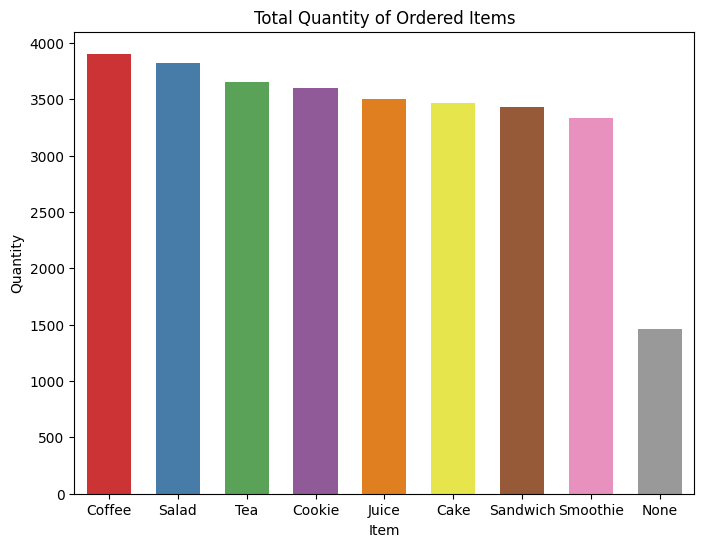

In [19]:
# Getting the total Quantity of each Item in the dataset
total_item_quantity = clean_cafesales.groupby('Item')['Quantity'].sum().reset_index()
total_item_quantity = total_item_quantity.sort_values(['Quantity'], ascending=False).reset_index()

# Plotting the bar graph
plt.figure(figsize=(8, 6))
plt.title("Total Quantity of Ordered Items")
sns.barplot(
    data=total_item_quantity,
    x='Item',
    y='Quantity',
    palette='Set1',
    gap=0.2,
)

<Axes: title={'center': 'Total Quantity of Valid Ordered Items'}, xlabel='Item', ylabel='Quantity'>

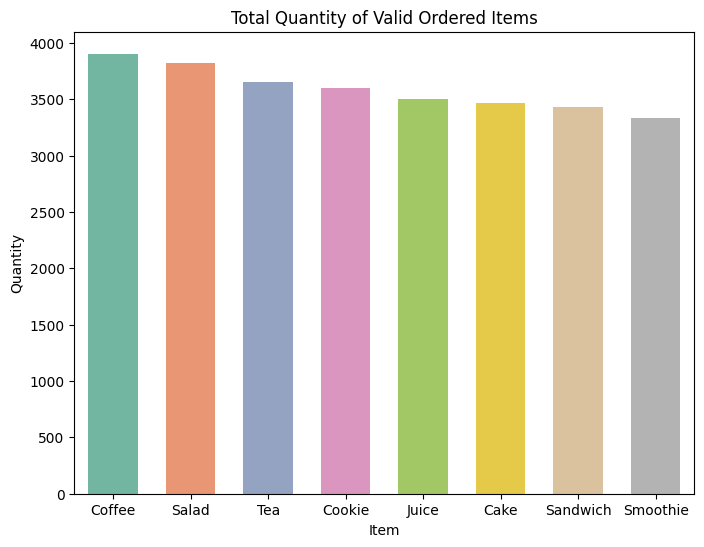

In [20]:
# Getting the total Quantity of each Item, excluding the blank(None) Item
total_valid_item_quantity = clean_cafesales.mask(clean_cafesales.eq('None').dropna())
total_valid_item_quantity = total_valid_item_quantity.groupby('Item')['Quantity'].sum().reset_index()
total_valid_item_quantity = total_valid_item_quantity.sort_values(['Quantity'], ascending=False).reset_index()

# Plotting the bar graph
plt.figure(figsize=(8, 6))
plt.title("Total Quantity of Valid Ordered Items")
sns.barplot(
    data=total_valid_item_quantity,
    x='Item',
    y='Quantity',
    palette='Set2',
    gap=0.2,
)

**Total Revenue per Month**

In [21]:
# Checking the different transaction dates for the dataset
clean_cafesales.describe()

,Quantity,Price Per Unit,Total Spent,Transaction Date
count,9974.000000,9974.000000,9974.000000,9514
mean,3.024865,2.946962,8.927411,2023-07-01 23:14:35.593861888
min,1.000000,1.000000,1.000000,2023-01-01 00:00:00
25%,2.000000,2.000000,4.000000,2023-04-01 00:00:00
50%,3.000000,3.000000,8.000000,2023-07-02 00:00:00
75%,4.000000,4.000000,12.000000,2023-10-02 00:00:00
max,5.000000,5.000000,25.000000,2023-12-31 00:00:00
std,1.420504,1.280144,6.002644,NaN


From this, it can be seen that the transactions all occurred in the year 2023. As such, the visualization will be the Total Revenue per Month for the year 2023. 

<Axes: title={'center': 'Total Revenue per Month'}, xlabel='Month', ylabel='Total Revenue'>

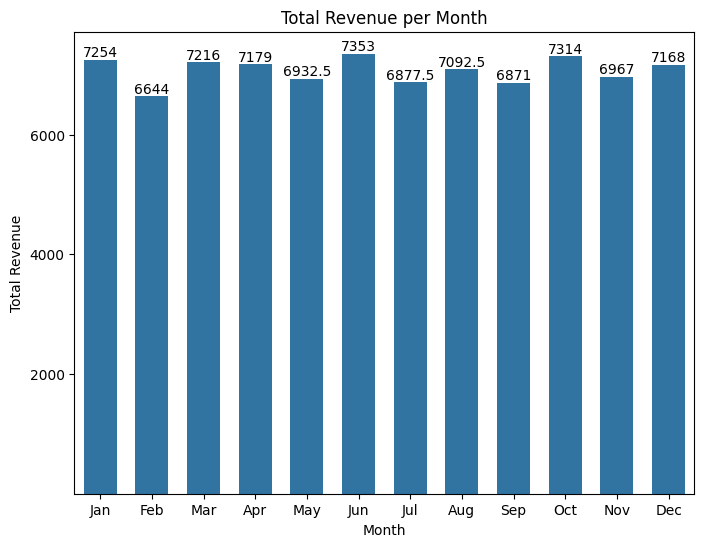

In [22]:
# Getting the Value of Total Spent per Month
total_revenue_per_month = clean_cafesales.dropna(subset=['Total Spent', 'Transaction Date'])
total_revenue_per_month = total_revenue_per_month.sort_values(['Transaction Date']).reset_index()

# Adding a column to represent the Month of the Transaction Date
total_revenue_per_month['Month'] = pd.to_datetime(total_revenue_per_month['Transaction Date']).dt.month
total_revenue_per_month = total_revenue_per_month.groupby('Month')['Total Spent'].sum().reset_index()

# Converting month number to month name
month_labels = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 
                8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
total_revenue_per_month['Month'] = total_revenue_per_month['Month'].apply(lambda x: month_labels[x])

# Plotting the bar graph
plt.figure(figsize=(8, 6))
plt.title("Total Revenue per Month")
plt.xlabel('Month')
plt.ylabel('Total Revenue')
plt.yticks([2000,4000,6000,8000])
ax = sns.barplot(data=total_revenue_per_month,
                x='Month',
                y='Total Spent',
                gap=0.2,)
ax.bar_label(ax.containers[0])
ax